# Home Exercise 1 on Text Classification
- Implement a Recurrent Neural Network model (Vanilla RNN, GRU, and LSTM) to predict whether a review is positive or negative.

- Data: IMDB Dataset of 50K Movie Reviews (the last 10% of rows serve as the test set).

  
- Compare the performance of the three models.

# Data downloading

In [1]:
!gdown 15XOhuhoOde7J4y8cCPAKEwDS3PlWcoHW -O archive.zip
# Unzip the specific file from the archive
!unzip archive.zip GMB_dataset.txt

Downloading...
From: https://drive.google.com/uc?id=15XOhuhoOde7J4y8cCPAKEwDS3PlWcoHW
To: /kaggle/working/archive.zip
100%|█████████████████████████████████████████| 473k/473k [00:00<00:00, 117MB/s]
Archive:  archive.zip
  inflating: GMB_dataset.txt         


# EDA and preprocess data

Starting data preprocessing and EDA...
Data loaded successfully.

Performing Exploratory Data Analysis...

1. Basic dataset statistics:
- Total rows: 66161
- Columns: ['Unnamed: 0', 'Sentence #', 'Word', 'POS', 'Tag']
- Sample data:
   Unnamed: 0  Sentence #           Word  POS Tag
0           0         1.0      Thousands  NNS   O
1           1         1.0             of   IN   O
2           2         1.0  demonstrators  NNS   O
3           3         1.0           have  VBP   O
4           4         1.0        marched  VBN   O

2. Missing values analysis:
Unnamed: 0    0
Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

Filled NaN values in 'Sentence #' column.

3. Tag distribution:
Tag
O        56217
B-geo     2070
B-org     1237
I-per     1234
B-gpe     1230
B-tim     1160
B-per     1107
I-org      926
I-geo      414
I-tim      334
B-art       53
B-eve       45
I-eve       37
I-gpe       34
I-art       34
B-nat       20
I-nat        9
Name: count, dtype: i

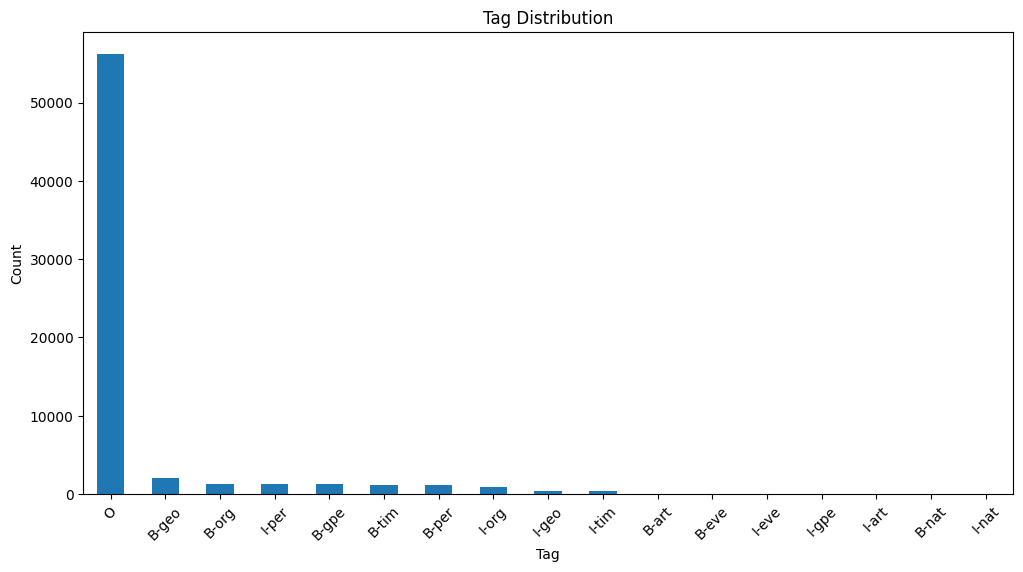

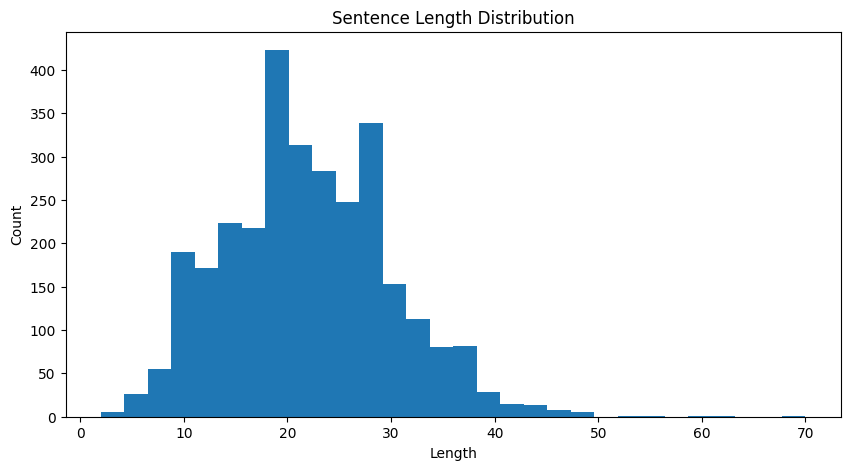

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

print("Starting data preprocessing and EDA...")

# Load the dataset
data = pd.read_csv('GMB_dataset.txt', delimiter='\t', encoding='latin1')
print("Data loaded successfully.")

# =============================================
# Exploratory Data Analysis (EDA)
# =============================================

print("\nPerforming Exploratory Data Analysis...")

# 1. Basic dataset statistics
print("\n1. Basic dataset statistics:")
print(f"- Total rows: {len(data)}")
print(f"- Columns: {list(data.columns)}")
print("- Sample data:")
print(data.head())

# 2. Check for missing values
print("\n2. Missing values analysis:")
print(data.isnull().sum())

# Fill NaN values in the 'Sentence #' column
data['Sentence #'] = data['Sentence #'].ffill()
print("\nFilled NaN values in 'Sentence #' column.")

# 3. Tag distribution analysis
print("\n3. Tag distribution:")
tag_counts = data['Tag'].value_counts()
print(tag_counts)

# 4. Sentence length analysis
sent_grouped = data.groupby('Sentence #')
sentence_lengths = sent_grouped.size()
print("\n4. Sentence length statistics:")
print(f"- Average length: {sentence_lengths.mean():.2f}")
print(f"- Min length: {sentence_lengths.min()}")
print(f"- Max length: {sentence_lengths.max()}")
print(f"- 90th percentile: {sentence_lengths.quantile(0.9)}")

# 5. Example sentences
print("\n5. Example sentences:")
for i, (name, group) in enumerate(sent_grouped):
    if i >= 2:  # Show first 2 sentences only
        break
    print(f"\nSentence {i+1}:")
    print("Words:", " ".join(group['Word'].tolist()))
    print("Tags:", " ".join(group['Tag'].tolist()))


import matplotlib.pyplot as plt
# Tag distribution plot
plt.figure(figsize=(12,6))
tag_counts.plot(kind='bar')
plt.title('Tag Distribution')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Sentence length distribution
plt.figure(figsize=(10,5))
plt.hist(sentence_lengths, bins=30)
plt.title('Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()


# Split data train and test (The last 10% sentence is used for test)

In [3]:
# =============================================
# Data Preparation for Model (Modified Version)
# =============================================

print("\nPreparing data for model with train-only vocab and last 10% test split...")

# Group by sentence to create list of (word, tag) pairs
sentences = data.groupby('Sentence #').apply(
    lambda x: list(zip(x['Word'], x['Tag']))
).tolist()

# Split data - last 10% as test set
total_sentences = len(sentences)
test_size = int(0.1 * total_sentences)
train_sentences = sentences[:-test_size]
test_sentences = sentences[-test_size:]
print(f"Split data into training ({len(train_sentences)} sentences) and test ({len(test_sentences)} sentences) sets - last 10% as test.")

# Get unique words from TRAIN SET ONLY
words = list(set(word for sentence in train_sentences for word, tag in sentence))
words.append('PAD')  # Add padding token
words.append('UNK')  # Add unknown token

# Get ALL unique tags (from both train and test)
tags = list(set(tag for sentence in sentences for word, tag in sentence))
print("Extracted unique words from TRAIN ONLY and all tags from FULL dataset.")

# Create mappings
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
print("Created word-to-index and tag-to-index mappings.")

# Convert sentences to indices (with UNK handling for test set)
def convert_sentence(sentence, is_train=True):
    if is_train:
        return [(word2idx[word], tag2idx[tag]) for word, tag in sentence]
    else:
        return [(word2idx.get(word, word2idx['UNK']), tag2idx[tag]) for word, tag in sentence]

train_sentences = [convert_sentence(s, is_train=True) for s in train_sentences]
test_sentences = [convert_sentence(s, is_train=False) for s in test_sentences]
print("Converted words and tags to indices (with UNK handling for test set).")

# Padding sequences
def pad_sequences(sequences, pad_token, pad_tag):
    max_len = max(len(s) for s in sequences)
    padded_sequences = []
    for seq in sequences:
        padded_seq = seq + [(pad_token, pad_tag)] * (max_len - len(seq))
        padded_sequences.append(padded_seq)
    return padded_sequences

# Add padding token to tag2idx
tag2idx['PAD'] = len(tag2idx)
pad_tag_idx = tag2idx['PAD']
print("Added padding token to tag2idx.")

# Pad sequences
train_sentences = pad_sequences(train_sentences, word2idx['PAD'], pad_tag_idx)
test_sentences = pad_sequences(test_sentences, word2idx['PAD'], pad_tag_idx)
print("Padded sequences.")

# Convert to PyTorch tensors
train_sentences = torch.tensor(train_sentences, dtype=torch.long)
test_sentences = torch.tensor(test_sentences, dtype=torch.long)
print("Converted data to tensors.")

# Separate word indices and tag indices
train_words = train_sentences[:, :, 0]  # Word indices
train_tags = train_sentences[:, :, 1]   # Tag indices
test_words = test_sentences[:, :, 0]    # Word indices
test_tags = test_sentences[:, :, 1]     # Tag indices
print("Separated word indices and tag indices.")


Preparing data for model with train-only vocab and last 10% test split...
Split data into training (2700 sentences) and test (299 sentences) sets - last 10% as test.
Extracted unique words from TRAIN ONLY and all tags from FULL dataset.
Created word-to-index and tag-to-index mappings.
Converted words and tags to indices (with UNK handling for test set).
Added padding token to tag2idx.
Padded sequences.
Converted data to tensors.
Separated word indices and tag indices.


<ipython-input-3-9a1b570c24ee>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentences = data.groupby('Sentence #').apply(


# Model define

In [4]:
# Step 2: Define the BiLSTM-CRF Model

print("Defining BiLSTM-CRF model...")

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds.view(len(x), 1, -1))
        lstm_out = lstm_out.view(len(x), -1)
        tag_space = self.hidden2tag(lstm_out)
        return tag_space

# CRF Layer
class CRF(nn.Module):
    def __init__(self, num_tags):
        super(CRF, self).__init__()
        self.num_tags = num_tags
        self.transitions = nn.Parameter(torch.randn(num_tags, num_tags))  # Transition scores

    def forward(self, feats, tags):
        """
        Compute the negative log-likelihood loss for a sequence.
        """
        seq_len = feats.shape[0]
        score = self._compute_score(feats, tags)  # Score of the gold path
        log_z = self._compute_log_partition(feats)  # Log partition function
        loss = log_z - score  # Negative log-likelihood
        return loss

    def _compute_score(self, feats, tags):
        """
        Compute the score of the gold path.
        """
        score = torch.zeros(1)
        score += feats[0, tags[0]]  # Start with the first tag
        for i in range(1, len(tags)):
            score += feats[i, tags[i]] + self.transitions[tags[i - 1], tags[i]]  # Emission + Transition
        return score

    def _compute_log_partition(self, feats):
        """
        Compute the log partition function using the forward algorithm.
        """
        seq_len, num_tags = feats.shape
        alpha = torch.zeros(num_tags)
        alpha = feats[0]  # Initialize with the first emission scores

        for t in range(1, seq_len):
            alpha_next = torch.zeros(num_tags)
            for i in range(num_tags):
                emit_score = feats[t, i]
                trans_score = self.transitions[:, i]
                alpha_next[i] = torch.logsumexp(alpha + trans_score, dim=0) + emit_score
            alpha = alpha_next

        log_z = torch.logsumexp(alpha, dim=0)
        return log_z

    def viterbi_decode(self, feats):
        """
        Decode the most likely sequence of tags using the Viterbi algorithm.
        """
        seq_len, num_tags = feats.shape
        backpointers = torch.zeros(seq_len, num_tags, dtype=torch.long)

        # Initialize the viterbi variables
        viterbi = feats[0]

        for t in range(1, seq_len):
            viterbi_next = torch.zeros(num_tags)
            for i in range(num_tags):
                trans_score = self.transitions[:, i]
                max_score, max_idx = torch.max(viterbi + trans_score, dim=0)
                viterbi_next[i] = max_score + feats[t, i]
                backpointers[t, i] = max_idx
            viterbi = viterbi_next

        # Backtrack to find the best path
        best_score, best_last_tag = torch.max(viterbi, dim=0)
        best_path = [best_last_tag.item()]
        for t in reversed(range(1, seq_len)):
            best_last_tag = backpointers[t, best_last_tag]
            best_path.insert(0, best_last_tag.item())

        return best_path

Defining BiLSTM-CRF model...


# Training model

In [5]:
# Hyperparameters
VOCAB_SIZE = len(word2idx)
TAGSET_SIZE = len(tag2idx)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128

# Initialize the model
model = BiLSTM_CRF(VOCAB_SIZE, TAGSET_SIZE, EMBEDDING_DIM, HIDDEN_DIM)
print("Initialized BiLSTM-CRF model.")

# Loss and optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
print("Initialized optimizer.")

# Step 3: Training Loop

print("Starting model training...")

num_epochs = 10
for epoch in range(num_epochs):  # Number of epochs
    model.train()
    total_loss = 0
    num_batches = len(train_words)
    
    for i in range(num_batches):  # Iterate over sentences
        sentence = train_words[i]      # Word indices for the sentence
        tags = train_tags[i]           # Tag indices for the sentence
        
        # Forward pass
        model.zero_grad()
        tag_scores = model(sentence)  # Emission scores from the BiLSTM
        
        # Compute loss using the CRF layer
        loss = model.crf(tag_scores, tags)
        total_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print progress and loss
        if (i + 1) % 10 == 0:  # Print every 10 batches
            progress = (i + 1) / num_batches * 100
            print(f'Epoch {epoch + 1}, Batch {i + 1}/{num_batches} ({progress:.2f}%), Loss: {loss.item():.4f}')
    
    # Print average loss for the epoch
    avg_loss = total_loss / num_batches
    print(f'Epoch {epoch + 1} completed. Average loss: {avg_loss:.4f}')

print("Training completed.")

Initialized BiLSTM-CRF model.
Initialized optimizer.
Starting model training...
Epoch 1, Batch 10/2700 (0.37%), Loss: 25.8842
Epoch 1, Batch 20/2700 (0.74%), Loss: 11.6242
Epoch 1, Batch 30/2700 (1.11%), Loss: 12.8440
Epoch 1, Batch 40/2700 (1.48%), Loss: 15.9344
Epoch 1, Batch 50/2700 (1.85%), Loss: 19.7587
Epoch 1, Batch 60/2700 (2.22%), Loss: 6.7919
Epoch 1, Batch 70/2700 (2.59%), Loss: 12.9040
Epoch 1, Batch 80/2700 (2.96%), Loss: 12.1965
Epoch 1, Batch 90/2700 (3.33%), Loss: 12.4003
Epoch 1, Batch 100/2700 (3.70%), Loss: 31.6235
Epoch 1, Batch 110/2700 (4.07%), Loss: 10.7212
Epoch 1, Batch 120/2700 (4.44%), Loss: 12.5893
Epoch 1, Batch 130/2700 (4.81%), Loss: 11.2956
Epoch 1, Batch 140/2700 (5.19%), Loss: 14.8971
Epoch 1, Batch 150/2700 (5.56%), Loss: 0.9453
Epoch 1, Batch 160/2700 (5.93%), Loss: 18.5746
Epoch 1, Batch 170/2700 (6.30%), Loss: 9.2883
Epoch 1, Batch 180/2700 (6.67%), Loss: 12.5076
Epoch 1, Batch 190/2700 (7.04%), Loss: 23.7749
Epoch 1, Batch 200/2700 (7.41%), Loss: 

# Model Evalutation

- Since because I already add the padding into each sentence to so the model will have likely to predict this padding leading the accuracy more higher. So I only count the padding that I predict fail and the padding I right will not add into accuracy

In [6]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    correct_with_padding = 0
    total_with_padding = 0
    non_o_count = 0  # Counter for non-'O' tags
    tag_counter = {}  # Dictionary to count tag occurrences
    
    for i in range(len(test_words)):  # Iterate over sentences
        sentence = test_words[i]      # Word indices for the sentence
        tags = test_tags[i]           # Ground truth tags
        
        # Forward pass
        tag_scores = model(sentence)  # Emission scores from the BiLSTM
        
        # Decode the most likely sequence of tags
        predicted_tags = model.crf.viterbi_decode(tag_scores)
        
        # Calculate accuracy (both with and without padding)
        for tag_idx, predicted_tag_idx in enumerate(predicted_tags):
            # Accuracy including padding
            total_with_padding += 1
            if predicted_tag_idx == tags[tag_idx]:
                correct_with_padding += 1
                
            # Accuracy excluding padding (original calculation)
            if tags[tag_idx] != tag2idx['PAD'] or predicted_tag_idx != tag2idx['PAD']:
                if predicted_tag_idx == tags[tag_idx]:
                    correct += 1
                total += 1
        
        # Count non-'O' tags and tag statistics
        for tag_idx, predicted_tag_idx in enumerate(predicted_tags):
            # Skip when both are padding
            if tags[tag_idx] != tag2idx['PAD'] or predicted_tag_idx != tag2idx['PAD']:
                predicted_tag = list(tag2idx.keys())[list(tag2idx.values()).index(predicted_tag_idx)]  # Get tag name from index
                if predicted_tag != 'O':  # Only count non-'O' tags
                    non_o_count += 1
                
                # Count tag occurrences
                if predicted_tag in tag_counter:
                    tag_counter[predicted_tag] += 1
                else:
                    tag_counter[predicted_tag] = 1
    
    accuracy = correct / total if total > 0 else 0
    accuracy_with_padding = correct_with_padding / total_with_padding if total_with_padding > 0 else 0
    
    print(f'Test Accuracy (excluding padding): {accuracy * 100:.2f}%')
    print(f'Test Accuracy (including padding): {accuracy_with_padding * 100:.2f}%')
    print(f'Number of non-"O" tags predicted: {non_o_count}')
    
    # Print tag statistics
    print("\nTag prediction statistics:")
    for tag, count in tag_counter.items():
        print(f'{tag}: {count}')

Test Accuracy (excluding padding): 93.03%
Test Accuracy (including padding): 96.97%
Number of non-"O" tags predicted: 836

Tag prediction statistics:
O: 5536
B-tim: 112
I-tim: 22
B-org: 95
I-org: 81
B-per: 85
I-per: 119
B-gpe: 87
I-art: 1
B-geo: 192
I-geo: 33
B-nat: 1
B-eve: 4
I-eve: 4
